In [32]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from IPython.display import Image

# Structure d'un script/notebook simple avec Keras

-------------------------------
-------------------------------
- Charger les données
- Traiter les données (augmentation ? réduction ?)
- Gérer les labels (one-hot encoding)
- Découpage train/test
-------------------------------
-------------------------------
- Construire le modèle 
- Choisir la fonction de coût, des métriques, un algorithme d'optimisation 
- Compiler le modèle 
- Configurer l'entrainement (`batch_size`, `nb_epoch`, ...)
- Lancer l'entraînement 
-------------------------------
-------------------------------
- Lancer l'inférence sur les nouvelles données à labeliser 
- [Générer le fichier .csv de résultats à envoyer sur Kaggle] 
-------------------------------
-------------------------------

# Les données : Digit-Recognizer de Kaggle 

Reconnaissance de caractères manuscrits (0 à 9)

- Application aux chèques bancaires 
- Yann LeCun a créé le modèle LeNet-5 dans les années 90 sur ce type de problème ! 
- Benchmark en Deep Learning

Données déjà préparées : 
- découpage train/test 
- normalisation des données (preprocessing) 

Reste à faire : `one-hot encoding`

In [4]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

In [5]:
X_train = np.load('../data/digit-recognizer/X_train.npy')
X_test = np.load('../data/digit-recognizer/X_test.npy')

y_train = np.load('../data/digit-recognizer/y_train.npy')
y_test = np.load('../data/digit-recognizer/y_test.npy')

In [7]:
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (33600, 784)
X_test shape : (8400, 784)
y_train shape : (33600,)
y_test shape : (8400,)


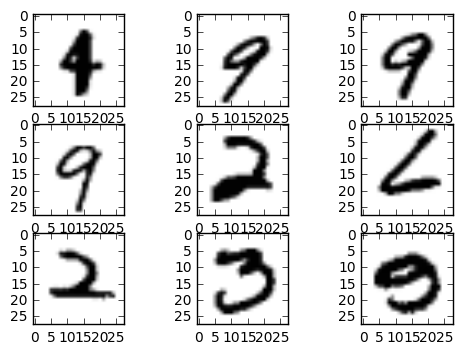

[4 9 9 9 2 6 2 3 9]


In [9]:
# Afficher quelques exemples 
for i in range(9):
    plt.subplot(331+i)
    #Les images sont sous forme de vecteurs, de taille 784=28x28
    plt.imshow(X_train[i].reshape(28,28), cmap=cm.binary)
plt.show()
print(y_train[:9])

 # Prendre en main Keras : régression logistique 

2 API pour construire un modèle avec Keras 
- **Sequential**
    - Empiler les couches, 1 entrée et 1 sortie 
- **Functional**
    - Plusieurs entrées et sorties ! 
 
Ce soir : `Sequential` uniquement !  
 
    
### Première étape :  construire le modèle

Caisse à outils : 

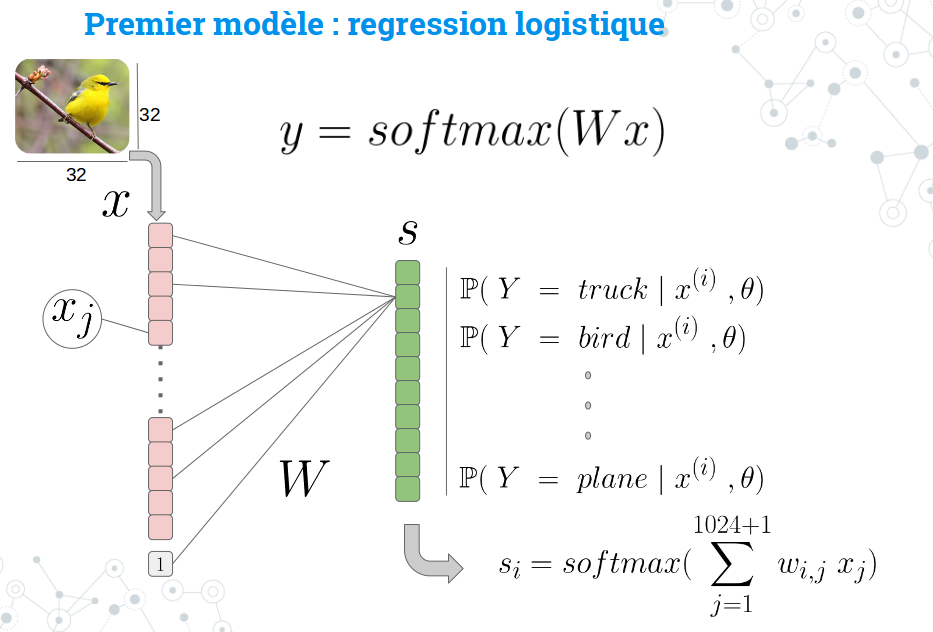

In [36]:
Image(filename='../../DeepLearning-NoBlaBla/ressources/regression_logistique.png')

- modèle non profond (aucune couche cachée)

In [38]:
#On charge l'API voulue
from keras.models import Sequential

#et les couches nécessaires 
from keras.layers import Dense, Activation

from keras.regularizers import l2

## La couche `Dense`

Couche 'full-connected' classique 

```python
keras.layers.core.Dense(output_dim, 
                        init='glorot_uniform',
                        activation=None,
                        weights=None,
                        W_regularizer=None,
                        b_regularizer=None,
                        activity_regularizer=None,
                        W_constraint=None,
                        b_constraint=None,
                        bias=True,
                        input_dim=None)
```

- **output_dim**: int > 0.
- **init**: nom de la règle d'initialisation des poids. (uniform, normal, identity, orthogonal, zero, one, glorot_normal, glorot_uniform, he_normal, he_uniform, ...)
- **activation**: nom de la fonction d'activation (pour l'instant `softmax`)
- **W_regularizer**: instance d'un `WeightRegularizer` (eg. L1 or L2 regularization), appliqué aux poids de la matrice.
- **b_regularizer**: instance d'un `WeightRegularizer`, appliqué au vecteur de biais.
- **input_dim**: dimension du vecteur d'entrée, à spécifier uniquement pour la première couche. 

-------------------------------------------------------

Comment ajouter la régularisation L2 ? 

```python 
from keras.regularizers import l2
model.add(Dense(64, input_dim=64, W_regularizer=l2(0.01)))
```

In [50]:
# On peut ensuite construire le modèle 
# En ajoutant les couches dans 'model'
model = Sequential()

# Dans la première couche, il faut toujours spécifier la dimension d'entrée ! Ici un vecteur de taille 784
model.add(Dense(10, input_dim=784, W_regularizer=l2(0.01)))
model.add(Activation('softmax'))

In [51]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 10)            7850        dense_input_7[0][0]              
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 10)            0           dense_4[0][0]                    
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
____________________________________________________________________________________________________


### Seconde étape : fonction de coût ? métriques ? algorithme d'optimisation ?

Métriques :
    - uniquement indicatives 
    - calculées sur chaque batch et pour les données de test (ou validation_data dans Keras)

Fonction de coût :
    - fonction à minimiser 
    - Cas de la classification multi-classes  : `categorical_crossentropy`


In [52]:
# Il existe beaucoup de méthodes d'optimisation : ce soir uniquement SGD 
from keras.optimizers import SGD

In [53]:
# choix du `learning rate` (il existe d'autres paramètres pour SGD)
sgd = SGD(lr=0.0001)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Troisième étape : entraînement

On indique : 
- les données d'entraînement (X_train,y_train)
- la taille des batch 
- le nombre d'epoch
- les données de test (ou validation) 

```python
model.fit(x, y,
          batch_size=32, nb_epoch=10, verbose=1,
          validation_split=0.0, validation_data=None,
          shuffle=True,
          class_weight=None, sample_weight=None,
          initial_epoch=0,
          callbacks=None)
```

In [54]:
from keras.utils.np_utils import to_categorical

In [55]:
batch_size = 32
nb_epoch = 30

history = model.fit(X_train, to_categorical(y_train,nb_classes=10),
                    batch_size = batch_size,
                    nb_epoch = nb_epoch,
                    verbose=1,
                    validation_data=(X_test, to_categorical(y_test,nb_classes=10)))


Train on 33600 samples, validate on 8400 samples
Epoch 1/30
33600/33600 [==============================] - 4s - loss: 10.1289 - acc: 0.3712 - val_loss: 8.0594 - val_acc: 0.4976
Epoch 2/30
33600/33600 [==============================] - 4s - loss: 6.5730 - acc: 0.5901 - val_loss: 5.9716 - val_acc: 0.6300
Epoch 3/30
33600/33600 [==============================] - 4s - loss: 5.6120 - acc: 0.6538 - val_loss: 5.4585 - val_acc: 0.6646
Epoch 4/30
33600/33600 [==============================] - 4s - loss: 5.2677 - acc: 0.6754 - val_loss: 5.1068 - val_acc: 0.6845
Epoch 5/30
33600/33600 [==============================] - 5s - loss: 4.5184 - acc: 0.7209 - val_loss: 4.1427 - val_acc: 0.7437
Epoch 6/30
33600/33600 [==============================] - 5s - loss: 3.9522 - acc: 0.7567 - val_loss: 3.8790 - val_acc: 0.7620
Epoch 7/30
33600/33600 [==============================] - 5s - loss: 3.7309 - acc: 0.7711 - val_loss: 3.7853 - val_acc: 0.7680
Epoch 8/30
33600/33600 [==============================] - 4s 

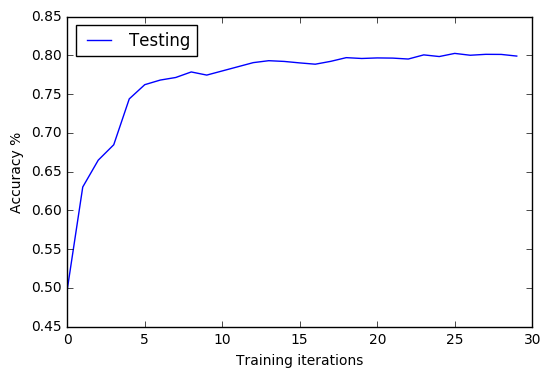

In [56]:
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy %')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()

## Appliquer le modèle à de nouvelles données 

In [26]:
test_data = np.load('../data/digit-recognizer/test_data.npy')
print(test_data.shape)

(28000, 784)


In [27]:
predictions = model.predict_classes(test_data,batch_size=128,verbose=1)

27392/28000 [============================>.] - ETA: 0s

In [28]:
predictions

array([2, 0, 6, ..., 3, 9, 2])

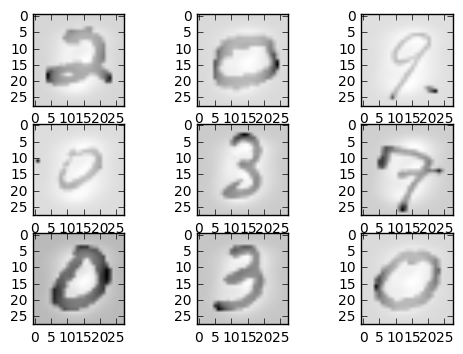

[2 0 6 6 3 7 0 3 0]


In [29]:
# Afficher quelques exemples 
for i in range(9):
    plt.subplot(331+i)
    #Les images sont sous forme de vecteurs, de taille 784=28x28
    plt.imshow(test_data[i].reshape(28,28), cmap=cm.binary)
plt.show()
print(predictions[:9])

In [30]:
# A faire chez soi : envoyerrésultats sur Kaggle
import pandas as pd

pd.DataFrame({"ImageId": list(range(1,len(test_data)+1)), 
              "Label": predictions}).to_csv('DIGIT-RECOGNIZER-submission.csv', index=False,header=True)

# Sauver son modèle

#### Uniquement l'architecture du modèle dans un fichier json

In [42]:
import json

json_string = model.to_json()

with open('model.json', 'w') as outfile:
    json.dump(json_string, outfile)

In [43]:
cat model.json

"{\"keras_version\": \"1.2.0\", \"config\": [{\"config\": {\"W_regularizer\": {\"name\": \"L1L2Regularizer\", \"l1\": 0.0, \"l2\": 0.009999999776482582}, \"activation\": \"linear\", \"W_constraint\": null, \"b_constraint\": null, \"b_regularizer\": null, \"init\": \"glorot_uniform\", \"trainable\": true, \"bias\": true, \"name\": \"dense_3\", \"batch_input_shape\": [null, 784], \"output_dim\": 10, \"activity_regularizer\": null, \"input_dim\": 784, \"input_dtype\": \"float32\"}, \"class_name\": \"Dense\"}, {\"config\": {\"name\": \"activation_3\", \"trainable\": true, \"activation\": \"softmax\"}, \"class_name\": \"Activation\"}], \"class_name\": \"Sequential\"}"

In [45]:
# Pour instacier un modèle depuis un fichier JSON : 
from keras.models import model_from_json

with open("model.json") as json_file:
    json_string = json.load(json_file)

model2 = model_from_json(json_string)
#Le modèle model2 a la même architecture, mais des poids différents (poids initiaux aléatoires)

#### Uniquement les poids entraînés dans un fichier hdf5

In [46]:
model.save_weights('weights.h5')

In [47]:
model2.load_weights('weights.h5')

#### Achitecture + poids entraînés dans un fichier hdf5

In [48]:
model.save('model_weights.h5')

In [49]:
from keras.models import load_model
model3 = load_model('model_weights.h5')

/root/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/models.py:150: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
